## Final Project Module 2: Statistical Analysis and Hypothesis Testing


* Student name: BRITTA BETTENDORF
* Student pace: FULL TIME
* Instructor name: RAFAEL CARRASCO

### The Scientific Method
<img src="The+Scientific+Method.jpg" height="50%" width="50%">

Based on this schema, my steps will be the same for every posed question:
#### 1. Doing some exploratory RESEARCH
- Exploring the existing data
- Feature engineering

#### 2. Defining the HYPOTHESIS
- Phrasing null hypothesis and alternative hypothesis
- Explaing why to use a one-tailed test (if directional hypothesis) or a two-tailed test (if non-directional hypothesis)
- Setting significance level

#### 3. STATISTICAL TESTING
- Reasoning the appropriate statistical test
- Checking its assumptions
- Calculating test statistic and p-value
- Calculating effect size

#### 4. Drawing CONCLUSIONS 
- Evaluating the results and interpret them

## Project Northwind Database

The Northwind database is a sample database used by Microsoft to demonstrate the features of some of its products, including SQL Server and Microsoft Access. The database contains the sales data for a fictitious company called Northwind Traders, which imports and exports specialty foods from around the world.

In [1]:
# import libraries
import sqlalchemy
import pandas as pd
import numpy as np

from sqlalchemy import create_engine
from sqlalchemy import inspect

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

In [2]:
# connecting to the Database using SQLAlchemy
engine = create_engine("sqlite:///Northwind_small.sqlite")

# create an inspector object
inspector = inspect(engine)

# get names of tables in database
print(inspector.get_table_names())

['Category', 'Customer', 'CustomerCustomerDemo', 'CustomerDemographic', 'Employee', 'EmployeeTerritory', 'Order', 'OrderDetail', 'Product', 'Region', 'Shipper', 'Supplier', 'Territory']


In [3]:
# write a quick function that prints the columns of a table and each column's type

def get_columns_info(table_name):    
    """ Function takes in table name and prints columns' names
    and datatypes """
    
    cols_list = inspector.get_columns(table_name)    
    print(f"Table Name: {table_name}\n")
    for col in cols_list:
        print(f"Name: {col['name']} \t Type: {col['type']}")

In [4]:
# calling the function to test it
get_columns_info('OrderDetail')

Table Name: OrderDetail

Name: Id 	 Type: VARCHAR(8000)
Name: OrderId 	 Type: INTEGER
Name: ProductId 	 Type: INTEGER
Name: UnitPrice 	 Type: DECIMAL
Name: Quantity 	 Type: INTEGER
Name: Discount 	 Type: FLOAT


## 1. Question: Preferences vs. Sales

> Do customers spend significantly more money on imported products than on domestic ones? So might there be a chance to sell more by focussing on imported products?

### 1.1 - Exploratory Research

In [5]:
get_columns_info('Order')

Table Name: Order

Name: Id 	 Type: INTEGER
Name: CustomerId 	 Type: VARCHAR(8000)
Name: EmployeeId 	 Type: INTEGER
Name: OrderDate 	 Type: VARCHAR(8000)
Name: RequiredDate 	 Type: VARCHAR(8000)
Name: ShippedDate 	 Type: VARCHAR(8000)
Name: ShipVia 	 Type: INTEGER
Name: Freight 	 Type: DECIMAL
Name: ShipName 	 Type: VARCHAR(8000)
Name: ShipAddress 	 Type: VARCHAR(8000)
Name: ShipCity 	 Type: VARCHAR(8000)
Name: ShipRegion 	 Type: VARCHAR(8000)
Name: ShipPostalCode 	 Type: VARCHAR(8000)
Name: ShipCountry 	 Type: VARCHAR(8000)


In [6]:
# joining "Supplier", "Product", "OrderDetail", "Order" and "Customer" tables 
# using the pd.read_sql_query() method and giving them meaningful column names in that step

df1 = pd.read_sql_query('''SELECT p.Id product_id, p.ProductName product_name, s.Id supplier_id, 
                            s.Country supplier_country, s.Region supplier_region, od.Quantity order_quantity,
                            od.UnitPrice unit_price, c.Id customer_id, c.Country customer_country, 
                            c.Region customer_region
                            FROM Supplier s
                            JOIN Product p ON s.Id = p.SupplierId
                            JOIN OrderDetail od ON p.Id = od.ProductId
                            JOIN [Order] o ON od.OrderId = o.Id
                            JOIN Customer c ON o.CustomerId = c.Id
                            ;''', engine)

In [7]:
print('1. Rows and Columns:')
print(df1.shape)
print('...............................')
print('\n2. Info:')
print(df1.info())
print('...............................\n\n3. Dataframe:')
df1.head()

1. Rows and Columns:
(2078, 10)
...............................

2. Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2078 entries, 0 to 2077
Data columns (total 10 columns):
product_id          2078 non-null int64
product_name        2078 non-null object
supplier_id         2078 non-null int64
supplier_country    2078 non-null object
supplier_region     2078 non-null object
order_quantity      2078 non-null int64
unit_price          2078 non-null float64
customer_id         2078 non-null object
customer_country    2078 non-null object
customer_region     2078 non-null object
dtypes: float64(1), int64(3), object(6)
memory usage: 162.4+ KB
None
...............................

3. Dataframe:


,product_id,product_name,supplier_id,supplier_country,supplier_region,order_quantity,unit_price,customer_id,customer_country,customer_region
0,11,Queso Cabrales,5,Spain,Southern Europe,12,14.0,VINET,France,Western Europe
1,42,Singaporean Hokkien Fried Mee,20,Singapore,South-East Asia,10,9.8,VINET,France,Western Europe
2,72,Mozzarella di Giovanni,14,Italy,Southern Europe,5,34.8,VINET,France,Western Europe
3,14,Tofu,6,Japan,Eastern Asia,9,18.6,TOMSP,Germany,Western Europe
4,51,Manjimup Dried Apples,24,Australia,NSW,40,42.4,TOMSP,Germany,Western Europe


### Feature Engineering

In [8]:
# Whenever supplier_country and customer_country match,
# the new "country_preference" column will be labeled "domestic", otherwise "imported"
df1['country_preference'] = np.where(df1['supplier_country'] == df1['customer_country'], 'domestic', 'imported')
df1['country_preference'].value_counts()

imported    1945
domestic     133
Name: country_preference, dtype: int64

Okay, in terms of numbers this is **too obvious**, so let's make it more difficult and define imported vs. domestic via regions:

In [9]:
# Whenever supplier_REGION and customer_REGION match,
# the new "region_preference" column will be labeled "domestic", otherwise "imported"
df1['region_preference'] = np.where(df1['supplier_region'] == df1['customer_region'], 'domestic', 'imported')
df1['region_preference'].value_counts()

imported    1780
domestic     298
Name: region_preference, dtype: int64

In [10]:
# constructing a column with the amount spent
df1['spending'] = np.multiply(df1['order_quantity'], df1['unit_price'])

# if preference is domestic, then fill domestic_spending with according spending - if not, make it zero
df1['domestic_spending'] = np.where(df1['region_preference'] == 'domestic', df1['spending'], 0.0)

# same vice versa
df1['imported_spending'] = np.where(df1['region_preference'] == 'imported', df1['spending'], 0.0)

df1.head(2)

,product_id,product_name,supplier_id,supplier_country,supplier_region,order_quantity,unit_price,customer_id,customer_country,customer_region,country_preference,region_preference,spending,domestic_spending,imported_spending
0,11,Queso Cabrales,5,Spain,Southern Europe,12,14.0,VINET,France,Western Europe,imported,imported,168.0,0.0,168.0
1,42,Singaporean Hokkien Fried Mee,20,Singapore,South-East Asia,10,9.8,VINET,France,Western Europe,imported,imported,98.0,0.0,98.0


In [11]:
# drop all columns we don't need and group by customer
df1_test = df1[['customer_id', 'domestic_spending', 'imported_spending']]
df1_test = df1_test.groupby('customer_id').sum()

In [12]:
print('1. Rows and Columns:')
print(df1_test.shape)
print('...............................')
print('\n2. Info:')
print(df1_test.info())
print('...............................\n\n3. Dataframe:')
df1_test.head()

1. Rows and Columns:
(85, 2)
...............................

2. Info:
<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, ALFKI to WOLZA
Data columns (total 2 columns):
domestic_spending    85 non-null float64
imported_spending    85 non-null float64
dtypes: float64(2)
memory usage: 2.0+ KB
None
...............................

3. Dataframe:


,domestic_spending,imported_spending
customer_id,,
ALFKI,2534.2,2062.00
ANATR,0.0,1402.95
AROUT,4335.0,9471.50
BERGS,879.5,26088.65
BLAUS,940.8,2299.00


### 1.2 - Hypothesis

$H_0$: People do not spend more money on imported food, so the difference of average spending is zero (or less).

> $H_0: \mu_d =< 0$

$H_1$: People spend more money on imported products.

> $H_1:  \mu_d > 0$

I set my significance level: 

> **$\alpha$ = 0.05**

As I specify the direction of the difference, it's a **one-tailed** test.

### 1.3 - Statistical Analysis

### Appropriate Test

To determine whether the mean difference between two unrelated groups is statistically significantly different from zero, the **independent t-test** is used.

The test statistic t follows a **t-Distribution with ($n_1$ + $n_2$ - 2) degrees of freedom**, where $n_1$ ist the size of sample 1 and $n_2$ ist the size of sample 2. 

### t-test Assumptions

* The **independent variable is categorical** with at least two levels (groups). <br> This assumption is met, as "food_preference" is either "domestic" or "imported".

* The **dependent variable must be continuous** which is measured on an interval or ratio scale. <br> This assumption is met, as "spending" is metric.

* The **dependent variable should not contain any significant outliers.**  <br> This can observed by using boxplots (see below).

* The **variances between the two groups are equal**. <br> This can be tested using statistical tests e.g. Levene’s test (see below).

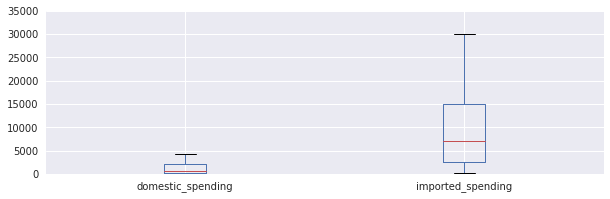

In [13]:
# boxplots for checking outliers
df1_test[['domestic_spending', 'imported_spending']].plot(kind='box', ylim=(0, 35000), figsize=(10,3));

--> The no-outlier-Assumption is met.

In [14]:
# Levene Test for testing homogeneity of variances
from scipy import stats
stats.levene(df1_test['domestic_spending'], df1_test['imported_spending'])

LeveneResult(statistic=11.696748186462553, pvalue=0.0007859534371347589)

--> The test is significant meaning there is **no homogeneity of variances and we can't proceed**. A viable alternative would be to conduct a **Welch’s t-test**, also named "unequal variances t-test".

### Welch’s t-test Assumptions

The first three assumptions for the t-Test were already passed. Lastly we're testing:

* The **distribution of the two groups should follow the normal distribution**. <br> This can be tested using Shapiro test (see below).

In [15]:
# testing normality for first group
stats.shapiro(df1_test['domestic_spending'])

(0.4288530945777893, 1.4724160334067695e-16)

In [16]:
# testing normality for second group
stats.shapiro(df1_test['imported_spending'])

(0.6535995602607727, 7.408941082170939e-13)

--> Shapiro’s test is significant which indicates that the groups are **not normally distributed**.

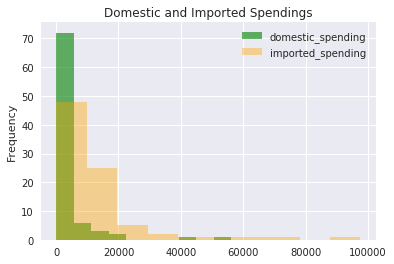

In [17]:
# additional histograms for visual inspection for what we already know
plt.figure(figsize=(6,4))
df1_test['domestic_spending'].plot(kind='hist', color='green', alpha=0.6, legend=True)
df1_test['imported_spending'].plot(kind='hist',  color='orange', alpha=0.4, legend=True)
plt.title('Domestic and Imported Spendings');

Yes, it's not normally distributed, but **Welch's t-test remains robust for skewed distributions** and large sample sizes. 

Nevertheless, we should keep in mind, reliability decreases for skewed distributions and smaller samples.

### Test Statistic

To conduct a Welch's t-Test, we just use the stats.ttest_ind() method and passing “False” in the equal_var-argument. It returns the t statistic and a p-value - but (!) for a two-tailed test.

In [18]:
# calculating t-value and two-tailed p-value 
t, p_two = stats.ttest_ind(df1_test['imported_spending'], df1_test['domestic_spending'], 
                           equal_var=False)
t

4.519665767821693

We now have the t-value. What's left are the degrees of freedom to finally get an accurate p-value for our one-tailed test.

In [19]:
# writing a function that calculates degrees of freedom

def welch_df(a, b):
    """ Calculates the effective degrees of freedom for two samples. """
    s1 = a.var(ddof=1) 
    s2 = b.var(ddof=1)
    n1 = a.size
    n2 = b.size    
    num = (s1/n1 + s2/n2)**2
    denom = (s1/n1)**2/(n1 - 1) + (s2/ n2)**2/(n2 - 1)
    df = num/denom
    return round(df,0)

df = welch_df(df1_test['imported_spending'], df1_test['domestic_spending'])
df

124.0

Eventually I calculate the p-value resp. the **area of rejecting the null hypothesis**. 

Given our directional alternative hypothesis: 

> $\mu_d > 0$

this area of rejecting is on the right (" > 0 "). 

In other words: I'm trying to get the probability that my test statistic exists GIVEN the null hypothesis is true. If this probabilty is very small, I won't continue assuming the null hypothesis but reject it and instead work with the alternative hypothesis.

In [20]:
# using the cumulative density function (CDF) with the t-value und df
p = 1 - stats.t.cdf(t, df)
p

7.129045843212722e-06

The findings **are statistically significant**! We can reject the null hypothesis in support of the alternative.

### Effect Size

For different types of t-Tests, a widely used measure of effect size is Cohens'd.

To calculate Cohen's d, the function below will take in the two samples we compare and by calculating the mean and standard deviation, eventually returns Cohen's d:

In [21]:
from statistics import mean, stdev
from math import sqrt

def cohens_d(x, y):
    """ Function takes in two samples as arguments and 
    calculates Cohens's as a measure of effect size. """
    cohens_d = (mean(x) - mean(y)) / (sqrt((stdev(x)**2 + stdev(y)**2) / 2))
    print(cohens_d)

In [22]:
cohens_d(df1_test['imported_spending'], df1_test['domestic_spending'])

0.6932850810422416


Not bad! A value > 0.5 is considered as medium effect, while a value > 0.8 already is considered a strong effect. 

**With 0.7 we're close to a strong effect.**

### 1.4 - Conclusions

In [23]:
df1_test.describe()

,domestic_spending,imported_spending
count,85.000000,85.000000
mean,3296.524118,12134.546941
std,8142.956245,16084.684694
min,0.000000,100.800000
25%,99.000000,2580.400000
50%,543.500000,6973.630000
75%,2080.000000,14987.050000
max,56220.890000,97539.990000


**A one-tailed Welch's t-test on an $\alpha$ = 0.05 was used to analyze customers' spending on domestic and imported products with the hypothesis that people spend more money on imported products:**

* The average expenditures on imported products are much higher (12134 ± 16084 units) compared to the expenditures on domestic products (3296 ± 8142 units).

* There is a **statistically highly significant difference** between domestic and imported expenditures with t(124) = 4.5197 and p = 0.000007129.

* Therefore I may reject the null hypothesis in support of the alternative: People spend more money on exotic products.

* Moreover, the calculated effect size is almost strong pointing to a **medium to high practical significance**.

* My $\alpha$ = 0.05 effectively is the probability that I mistakenly reject the null hypothesis when it is actually true. This is called the "Type 1 Error". <br> With 5% I accept only a very small probability for Type 1 Error. The opposite is the "Type 2 Error" where I may mistakenly support the null hypothesis when the alternative is actually true.

**The results could be used to think about a strategy focussing on imported products for different regions to maximize revenues.**

## 2. Question: Frequency vs. Profitability

> Do people who order more frequently also generate more sales? If so, it would probably make sense to prompt customers selling more often, even for little money.

### 2.1 - Exploratory Research

In [24]:
get_columns_info('Customer')

Table Name: Customer

Name: Id 	 Type: VARCHAR(8000)
Name: CompanyName 	 Type: VARCHAR(8000)
Name: ContactName 	 Type: VARCHAR(8000)
Name: ContactTitle 	 Type: VARCHAR(8000)
Name: Address 	 Type: VARCHAR(8000)
Name: City 	 Type: VARCHAR(8000)
Name: Region 	 Type: VARCHAR(8000)
Name: PostalCode 	 Type: VARCHAR(8000)
Name: Country 	 Type: VARCHAR(8000)
Name: Phone 	 Type: VARCHAR(8000)
Name: Fax 	 Type: VARCHAR(8000)


In [25]:
# joining "Order", "OrderDetail" and "Customer" tables using the pd.read_sql_query() method 
# giving them meaningful column names in that step

df2 = pd.read_sql_query('''SELECT c.Id customer_id, o.Id order_id,
                            od.Quantity quantity, od.UnitPrice unit_price, od.discount discount
                            FROM OrderDetail od 
                            JOIN [Order] o ON od.OrderId = o.Id
                            JOIN Customer c ON o.CustomerId = c.Id
                            ;''', engine)

In [26]:
print('1. Rows and Columns:')
print(df2.shape)
print('...............................')
print('\n2. Info:')
print(df2.info())
print('...............................\n\n3. Dataframe:')
df2.head()

1. Rows and Columns:
(2078, 5)
...............................

2. Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2078 entries, 0 to 2077
Data columns (total 5 columns):
customer_id    2078 non-null object
order_id       2078 non-null int64
quantity       2078 non-null int64
unit_price     2078 non-null float64
discount       2078 non-null float64
dtypes: float64(2), int64(2), object(1)
memory usage: 81.2+ KB
None
...............................

3. Dataframe:


,customer_id,order_id,quantity,unit_price,discount
0,VINET,10248,12,14.0,0.0
1,VINET,10248,10,9.8,0.0
2,VINET,10248,5,34.8,0.0
3,TOMSP,10249,9,18.6,0.0
4,TOMSP,10249,40,42.4,0.0


In [27]:
# calculate the mean and median amount of orders
mean = df2.groupby('customer_id')['order_id'].count().mean()
median = df2.groupby('customer_id')['order_id'].count().median()
print('Mean:  ', mean)
print('Median:', median)

Mean:   24.44705882352941
Median: 20.0


It's usually more appropriate to stick to the median.

### Feature Engineering

In [28]:
# multiplying quantity and unit price to get a column with gross spending
df2['spend_gross'] = np.multiply(df2['quantity'], df2['unit_price'])

# subtracting discount to get net spending
df2['spend_net'] = np.subtract(df2['spend_gross'], df2['discount'])

df2.head(2)

,customer_id,order_id,quantity,unit_price,discount,spend_gross,spend_net
0,VINET,10248,12,14.0,0.0,168.0,168.0
1,VINET,10248,10,9.8,0.0,98.0,98.0


In [29]:
# FIRST dataframe by spending
df2_spending = df2.groupby('customer_id')[['spend_gross','spend_net']].sum()
df2_spending.head(3)

,spend_gross,spend_net
customer_id,,
ALFKI,4596.20,4595.15
ANATR,1402.95,1402.95
AROUT,13806.50,13805.80


In [30]:
# SECOND dataframe by sales frequency
df2_frequency = pd.DataFrame(df2.groupby('customer_id')['order_id'].count())
df2_frequency.rename(columns={'order_id':'order_amount'}, inplace=True)
df2_frequency.head(3)

,order_amount
customer_id,
ALFKI,12
ANATR,10
AROUT,30


In [31]:
# creating a new column in second dataframe, 
# where all customer with a total amount of orders UP TO MEDIAN are classified as "Below Median"
# and all customers with a total amount of orders GREATER THAN MEDIAN as "Above Median"

df2_frequency['sales_frequency'] = df2_frequency['order_amount'].apply(lambda x: 'Below Median' 
                                                                       if x <= median 
                                                                       else 'Above Median')

df2_frequency.head(3)

,order_amount,sales_frequency
customer_id,,
ALFKI,12,Below Median
ANATR,10,Below Median
AROUT,30,Above Median


In [32]:
df2_frequency.sales_frequency.value_counts()

Below Median    43
Above Median    42
Name: sales_frequency, dtype: int64

In [33]:
# concat first and second dataframe
df2_full = pd.concat([df2_spending, df2_frequency], axis=1)
df2_full.head(3)

,spend_gross,spend_net,order_amount,sales_frequency
customer_id,,,,
ALFKI,4596.20,4595.15,12,Below Median
ANATR,1402.95,1402.95,10,Below Median
AROUT,13806.50,13805.80,30,Above Median


In [34]:
df2_full.shape

(85, 4)

### 2.2 - Hypothesis

$H_0$: People who order more frequently (= above the median) do not spend more money on average than people who order less frequent.

> $H_0: \mu_1 = \mu_2$

$H_1$: People who order more frequently also spend more money on average than people who order less frequent.

> $H_0: \mu_1 > \mu_2$

I set my significance level: 

> **$\alpha$ = 0.05**

As I specify the direction of the difference, it's a **one-tailed** test. 

### 2.3 - Statistical Analysis

### Appropriate Test

To determine whether the mean difference between two unrelated groups is statistically significantly different from zero, the **independent t-test** is used.

The test statistic t follows a **t-Distribution with ($n_1$ + $n_2$ - 2) degrees of freedom**, where $n_1$ ist the size of sample 1 and $n_2$ ist the size of sample 2. 

### t-test Assumptions

* The **independent variable is categorical** with at least two levels (groups). <br> This assumption is met, as sales frequency is categorized in either below or above median.

* The **dependent variable must be continuous** which is measured on an interval or ratio scale. <br> This assumption is met, as "spending" is metric.

* The **dependent variable should not contain any significant outliers.**  <br> This can observed by using boxplots (see below).

* The **variances between the two groups are equal**. <br> This can be tested using statistical tests e.g. Levene’s test (see below).

* The **distribution of the two groups should follow the normal distribution**. <br> This can be checked with histograms (see below).

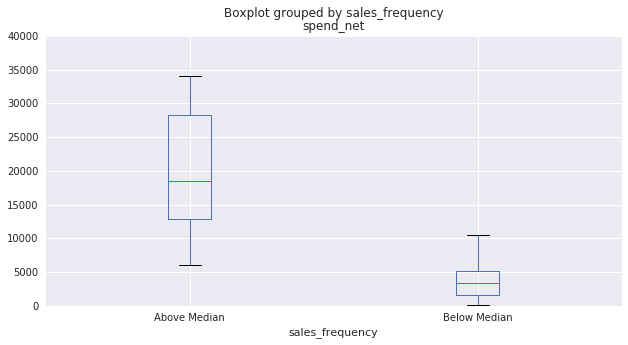

In [35]:
# boxplots for checking outliers
df2_full.boxplot('spend_net', by='sales_frequency', figsize=(10,5))
plt.ylim(0,40000);

--> The no-outlier-Assumption is met.

In [36]:
# Levene Test for testing homogeneity of variances
from scipy import stats

# create criteria for each sample
crit_above = df2_full['sales_frequency']=='Above Median'
crit_below = df2_full['sales_frequency']=='Below Median'

stats.levene(crit_above, crit_below)

LeveneResult(statistic=0.0, pvalue=1.0)

--> The test is not significant meaning there is homogeneity of variances and we can proceed.

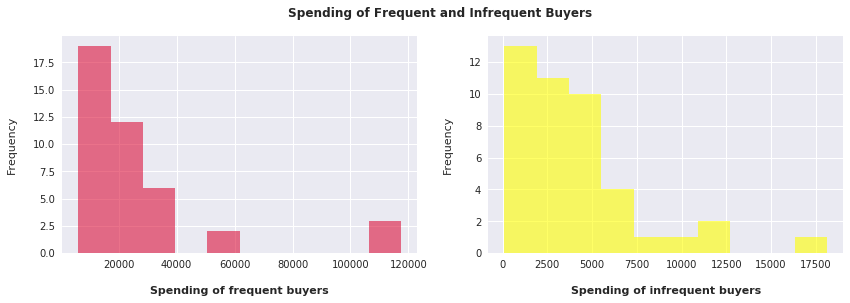

In [37]:
# seperate both samples
series_above = df2_full['spend_net'].where(crit_above).dropna()
series_below = df2_full['spend_net'].where(crit_below).dropna()

# plot histograms
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))

ax1.hist(series_above, color='crimson', alpha=0.6)
ax1.set_xlabel('\nSpending of frequent buyers', fontweight='bold')
ax1.set_ylabel('Frequency\n')

ax2.hist(series_below, color='yellow', alpha=0.6)
ax2.set_xlabel('\nSpending of infrequent buyers', fontweight='bold')
ax2.set_ylabel('Frequency\n')

plt.suptitle('Spending of Frequent and Infrequent Buyers', fontweight='bold');

--> It's **not normally distributed**, but the independent t-test remains quiet robust for violations of normality. 

Nevertheless, we should keep in mind, as a parametric test the independent t-test delievers best to interpret results if both groups are normally distributed. Reliability decreases for skewed distributions.

### Test Statistic

To conduct a t-Test, we just use the stats.ttest_ind() method. It returns the t statistic and a p-value - but (!) for a two-tailed test.

In [38]:
# calculating t-value and two-tailed p-value 
from scipy import stats
t, p_two = stats.ttest_ind(series_above, series_below)
t

5.430934452008424

We now have the t-value and only need to get the degrees of freedom for both samples to finally calculate an accurate p-value for our one-tailed test.

In [39]:
# checking the length of the above-sample
n1 = series_above.shape[0]
n1

42

In [40]:
# checking the length of the below-sample
n2 = series_below.shape[0]
n2

43

Lastly I calculate the p-value resp. the **area of rejecting the null hypothesis**. 

Given our directional alternative hypothesis: 

> $\mu_1 > \mu_2$ or stated differently: $\mu_1 - \mu_2 > 0$

this area of rejecting is on the right (" > 0 "). 

In other words: I'm trying to get the probability that my test statistic exists GIVEN the null hypothesis is true. If this probabilty is very small, I won't continue assuming the null hypothesis but reject it and instead work with the alternative hypothesis.

In [41]:
# using the cumulative density function (CDF) with the t-value und df's of both samples

p = 1 - stats.t.cdf(t, n1+n2-2)
p

2.7358377197028716e-07

The independent t-test results are **significant!** Therefore, we can reject the null hypothesis in support of the alternative.

#### Effect Size

To calculate the effect size, I use the function I created before for the first question:

In [42]:
from statistics import mean, stdev
from math import sqrt

def cohens_d(x, y):
    """ Function takes in two samples as arguments and 
    calculates Cohens's as a measure of effect size. """
    cohens_d = (mean(x) - mean(y)) / (sqrt((stdev(x)**2 + stdev(y)**2) / 2))
    print(cohens_d)

In [43]:
cohens_d(series_above, series_below)

1.1713479126118411


Cohen's d may also take values above 1 (it's defined from -∞ to +∞). In our case it's really an **eminently big effect**!

### 2.4 - Conclusions

In [44]:
print("\nFrequent Customers' Spending:")
print(series_above.describe())
print("\nInfrequent Customers' Spending:")
print(series_below.describe())


Frequent Customers' Spending:
count        42.000000
mean      26917.445238
std       27175.137126
min        6089.900000
25%       12894.525000
50%       18486.850000
75%       28280.957500
max      117477.440000
Name: spend_net, dtype: float64

Infrequent Customers' Spending:
count       43.000000
mean      4209.113953
std       3631.026596
min        100.800000
25%       1645.150000
50%       3361.000000
75%       5169.650000
max      18136.350000
Name: spend_net, dtype: float64


**A one-tailed t-test on an $\alpha$ = 0.05 was used to analyze whether customers who order more frequently also spend more money on average than customers who order less frequent:**

* A customer buying more often than the median value was classified as a frequent customer, every other customer as an infrequent customer.

* The average spending of a frequent customer is much higher (26917 ± 27175 units) than the average spending of a frequent customer (4209 ± 3631 units). Note that the standard deviation of the first may also lead to negative spendings, perhaps due to discounts.

* There was a **statistically highly significant difference** between both groups' expenditures with t(42) = 5.4309 and p = 0.00000055.

* Therefore I may reject the null hypothesis in support of the alternative: Frequent buyers also spend more money in general.

* Moreover, the calculated effect size is extremely high pointing to a **very big practical significance**.

* My $\alpha$ = 0.05 effectively is the probability that I mistakenly reject the null hypothesis when it is actually true. This is called the "Type 1 Error". <br> With 5% I accept only a very small probability for Type 1 Error. The opposite is the "Type 2 Error" where I may mistakenly support the null hypothesis when the alternative is actually true.

**The results could be used to think about a strategy prompting customers just selling more often, even for little money, in order to generate higher revenues.**

## 3. Question: Effect of Discount on Sales

> Does the discount amount have a statistically significant effect on the number of products in an order? If so, at what level(s) of discount?

### 3.1 - Exploratory Research

In [45]:
# using the pd.read_sql_query() method to get the "OrderDetail" table only
df3 = pd.read_sql_query('''SELECT * FROM OrderDetail;''', engine)

In [46]:
print('1. Rows and Columns:')
print(df3.shape)
print('...............................')
print('\n2. Info:')
print(df3.info())
print('...............................\n\n3. Dataframe:')
df3.head()

1. Rows and Columns:
(2155, 6)
...............................

2. Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
Id           2155 non-null object
OrderId      2155 non-null int64
ProductId    2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB
None
...............................

3. Dataframe:


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [47]:
df3.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

Due to the rare cases in some discount levels I'll drop these and work only with the no-discount group and the 5 groups of discount that have s substantial size of cases:

In [48]:
crit = (df3.Discount == 0.00) | (df3.Discount == 0.05) | (df3.Discount == 0.10) | (df3.Discount == 0.15) | (df3.Discount == 0.20) | (df3.Discount == 0.25)

df3_test = df3.loc[crit]
df3_test.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
Name: Discount, dtype: int64

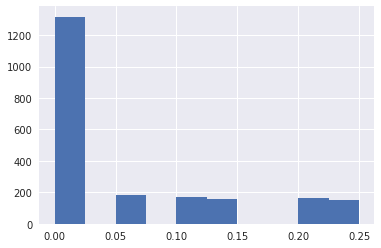

In [49]:
df3_test.Discount.hist(figsize=(6, 4));

--> Most customers don't get any discount and the five different discout levels itself are represented quiet evenly.

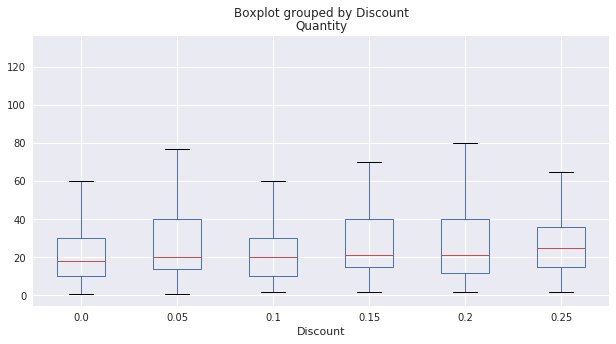

In [50]:
df3_test.boxplot('Quantity', by='Discount', figsize=(10, 5));

--> There are no outliers in each discount group with respect to the quantity.

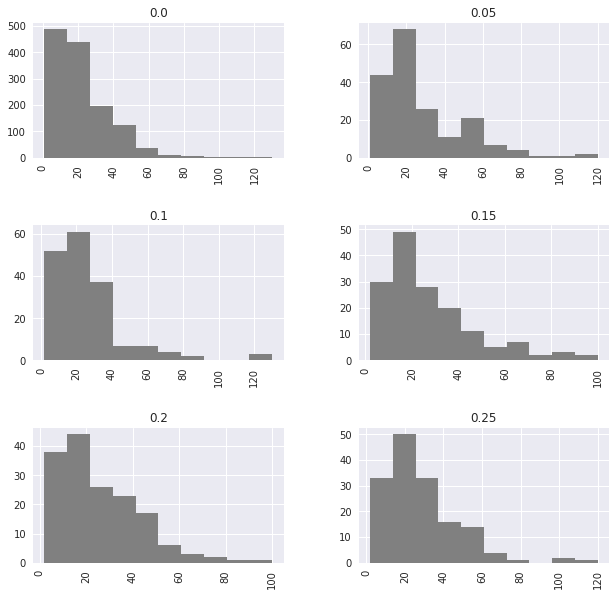

In [51]:
df3_test.hist('Quantity', by='Discount', figsize=(10, 10), color='grey');

### 3.2 - Hypothesis

$H_0$: The average number of products in an order is equal for all levels of discount.

> $H_0: \mu_1 = \mu_2 = \mu_3 =  ...  = \mu_i ...  = \mu_j$

$H_1$: The average number of products in an order differs between at least two levels of discount.

> $H_0: \mu_i \neq \mu_j$

I set my significance level: 

> **$\alpha$ = 0.05**

### 3.3 - Statistical Analysis

### Appropriate Test

The analysis of variance or **one-way ANOVA** is used when one wants to compare the means of a condition between 2+ groups. It can be thought of as an extension to the t-test that is used to compare the means of a condition between 2 groups. ANOVA is an omnibus test, meaning it tests the data as a whole. Another way to say that is this, ANOVA tests if there is a difference in the mean somewhere in the model (testing if there was an overall effect), but it does not tell one where the difference is if the there is one. To find out where the difference is between the groups, one has to conduct post-hoc tests. 

Although it can be thought of as an extension of the t-test, in terms of when to use it, mathematically speaking, it’s more of a regression model and is considered a generalized linear model (GLM).

The test statistic F follows an **F-Distribution with $q$ - 1 degrees of freedom** with $q$ being the number of groups. 

Because of the F-Distribution's shape, the significance level is always specified on the right (no one-tailed or two-tailed specification is necessary).

### ANOVA Assumptions

There are 3 assumptions that need to be met for the results of an ANOVA test to be considered accurate and trust worthy. It’s important to note that **two assumptions apply to the residuals** and not the variables themselves. The ANOVA assumptions are the same as for linear regression and are:


* **Normality** <br> Caveat to this is, if group sizes are equal, the F-statistic is robust to violations of normality.
    
* **Homogeneity of variance** <br> Same caveat as above, if group sizes are equal, the F-statistic is robust to this violation.

* **Independent observations**

If possible, it is best to have groups the same size so corrections to the data do not need to be made. Fortunately, we deal with equally sized groups here.

As two of the assumptions apply to the residuals, they are tested after conducting the ANOVA. The independence of oberservations can be assumed!

### Test Statistic

In [52]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# syntax for defining the ANOVA-model
anova = ols('Quantity ~ Discount', data=df3_test).fit()
table = sm.stats.anova_lm(anova, typ=2)
table

,sum_sq,df,F,PR(>F)
Discount,12621.238965,1.0,35.487951,2.991487e-09
Residual,762866.181622,2145.0,NaN,NaN


On the left, we have our discount factor, and on the right, the probability that this factor is indeed influential. 

Values < .05 (i.e. our α) indicate rejection of the null hypothesis. **We can see the discount factor appears to be highly influential.**

**Assumption of Homogeneity of residuals' variance:**

In [53]:
# using Levene’s test to test for equal variances between groups
from scipy import stats
stats.levene(df3_test['Quantity'][df3_test['Discount'] == 0.00],
             df3_test['Quantity'][df3_test['Discount'] == 0.05],
             df3_test['Quantity'][df3_test['Discount'] == 0.10],
             df3_test['Quantity'][df3_test['Discount'] == 0.15],
             df3_test['Quantity'][df3_test['Discount'] == 0.20],
             df3_test['Quantity'][df3_test['Discount'] == 0.25])

LeveneResult(statistic=2.9943951679841643, pvalue=0.010664285577385134)

--> Levene’s test for homogeneity of variance is significant which indicates that the **groups don't have equal variances**. But as stated earlier, if group sizes are equal, the F-statistic is robust to this violation.

**Assumption of Normality of residuals:**

In [54]:
# using Shapiro-Wilk method
stats.shapiro(anova.resid)

(0.8587857484817505, 3.172497684277456e-40)

--> The output is not labelled, but the numbers are the test statistic value followed by the p-value. The results from the Shapiro-Wilk test is statistically significant which indicates that the **residuals are not normally distributed**. But same as above: if group sizes are equal, the F-statistic is robust to violation of normality.

### Effect Size

There are a few different effect sizes for an ANOVA one can use: **eta squared (η2)**, and **omega squared (ω2)**. Omega squared is considered a better measure of effect size than eta squared because it is unbiased in it’s calculation.

+++ Something to note: For some reason R2 is called eta squared within the ANOVA framework, but they are the same thing. R2 is a measure of how much variance is explained by the model and is calculated by taking the explained variance and dividing it by the total variance. +++

The following code uses the ANOVA table produced by statsmodels and appends the effect size measures of eta-squared (η2) and omega-squared (ω2).

In [55]:
def anova_effect_size(aov):       
    """ This function takes the Anova table performed with statsmodels
    and appends two effect size measures: eta-squared and omega-squared. """
    
    # mean squared
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    
    # eta-squared (η2) 
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    
    # omega-squared (ω2)
    num = (aov[:-1]['sum_sq'] - (aov[:-1]['df']*aov['mean_sq'][-1]))
    denom = (sum(aov['sum_sq']) + aov['mean_sq'][-1])
    aov['omega_sq'] = num / denom    
    
    return aov

anova_effect_size(table)

,sum_sq,df,F,PR(>F),mean_sq,eta_sq,omega_sq
Discount,12621.238965,1.0,35.487951,2.991487e-09,12621.238965,0.016275,0.015809
Residual,762866.181622,2145.0,NaN,NaN,355.648570,NaN,NaN


According to both measures (around 0.016), the discount has only a **small effect**.

### Post-hoc Testing

The overall model was significant, now we want to know **which groups actually differ**. 

Tukey’s HSD is one method that can be used. The Tukey HSD post-hoc comparison test controls for type I error and maintains the familywise error rate at 0.05. 

(Unfortunately, this method currently does not provide the t-statistic so treatment effect size cannot be calculated.)

In [56]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

mc = MultiComparison(df3_test['Quantity'], df3_test['Discount'])
mc_results = mc.tukeyhsd()

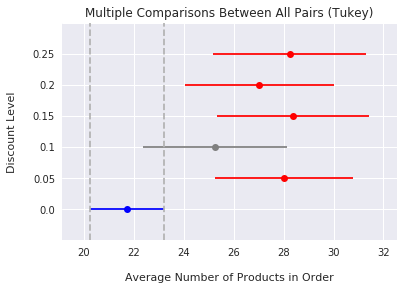

In [57]:
# let's compare all levels with 0.0 (blue)
# all groups that are significantly different from 0.0 are color coded red, all insignificant groups gray
mc_results.plot_simultaneous(comparison_name=0.0, figsize=(6,4), 
                             ylabel='Discount Level\n', xlabel='\nAverage Number of Products in Order');

--> **All discount levels significantly differ from NO DISCOUNT - except the 0.1% discount.**

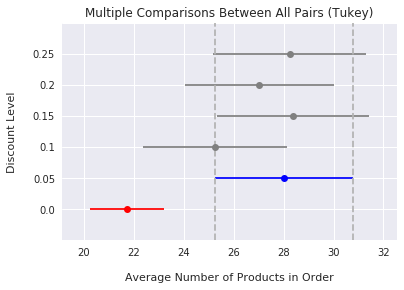

In [58]:
# let's compare all levels with 0.05 (blue)
# all groups that are significantly different are color coded red, all insignificant groups gray
mc_results.plot_simultaneous(comparison_name=0.05, figsize=(6,4),                            
                             ylabel='Discount Level\n', xlabel='\nAverage Number of Products in Order');

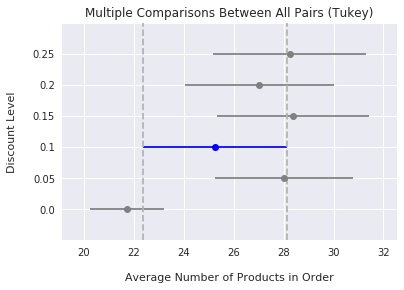

In [59]:
# let's compare all levels with 0.1 (blue)
# all groups that are significantly different are color coded red, all insignificant groups gray
mc_results.plot_simultaneous(comparison_name=0.1, figsize=(6,4), 
                             ylabel='Discount Level\n', xlabel='\nAverage Number of Products in Order');

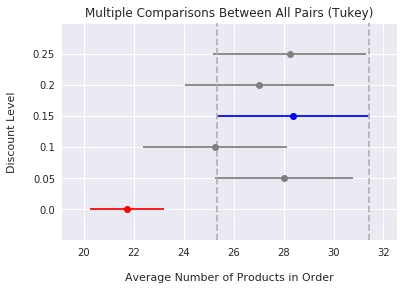

In [60]:
# let's compare all levels with 0.15 (blue)
# all groups that are significantly different are color coded red, all insignificant groups gray
mc_results.plot_simultaneous(comparison_name=0.15, figsize=(6,4), 
                             ylabel='Discount Level\n', xlabel='\nAverage Number of Products in Order');

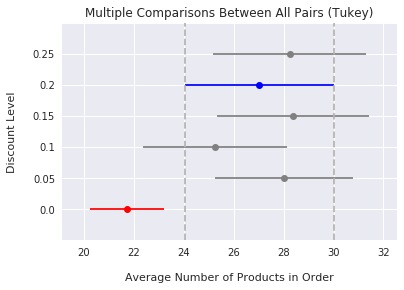

In [61]:
# let's compare all levels with 0.2 (blue)
# all groups that are significantly different are color coded red, all insignificant groups gray
mc_results.plot_simultaneous(comparison_name=0.2, figsize=(6,4), 
                             ylabel='Discount Level\n', xlabel='\nAverage Number of Products in Order');

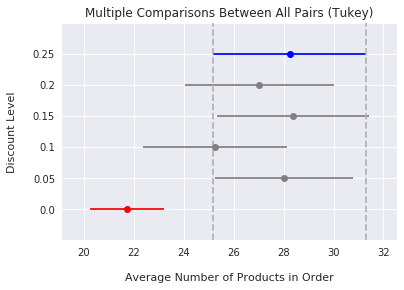

In [62]:
# let's compare all levels with 0.25 (blue)
# all groups that are significantly different are color coded red, all insignificant groups gray
mc_results.plot_simultaneous(comparison_name=0.25, figsize=(6,4), 
                             ylabel='Discount Level\n', xlabel='\nAverage Number of Products in Order');

--> **Some levels though seem to have an unwanted effect, e.g. 0.2: The number of ordered products becomes even less compared 0.15 or 0.05!**

### 3.4 - Conclusions

**An one-way ANOVA on an $\alpha$ = 0.05 was used to analyze the effect of discount levels on the number of items in an order:**

* There was a **statistically highly significant difference** between the discount levels with p = 2.991487e-09.

* Therefore I may reject the null hypothesis in support of the alternative: The average number of ordered products in an order differs between at least two levels of discounts. It seems that the number of items can't be increased by offering more discount than 0.05.

* Post-hoc testing revealed interesting details though in which groups actually differ. Further investigation may be needed but there is some evidence for e.g. a discount of 0.1 may be less productive than one of 0.15 or 0.25 (double-digits).

* However, the effect size is only small pointing to a **low practical significance**.

* My $\alpha$ = 0.05 effectively is the probability that I mistakenly reject the null hypothesis when it is actually true. This is called the "Type 1 Error". <br> With 5% I accept only a very small probability for Type 1 Error. The opposite is the "Type 2 Error" where I may mistakenly support the null hypothesis when the alternative is actually true.

**The results could be used to further investigate and maybe test the effect of different discount levels in their use to be productive revenue booster.**

## 4. Question: Influence of Gender and Categories on Sales

> What influence does have the gender and product category on the amount of sales? Are their interactions in that a specific gender responds well to specific categories?

### 4.1 - Exploratory Research

In [63]:
# joining "Order", "OrderDetail", "Customer", "Product" and "Category" tables
# using the pd.read_sql_query() method and giving them meaningful column names in that step

df4 = pd.read_sql_query('''SELECT c.Id customer_id, c.contactname contact_name, c.contacttitle title, 
                            o.Id order_id, od.Quantity quantity, od.UnitPrice unit_price, od.Discount discount,
                            cat.Id cat_id, cat. CategoryName cat_name
                            FROM OrderDetail od 
                            JOIN [Order] o ON od.OrderId = o.Id
                            JOIN Customer c ON o.CustomerId = c.Id
                            JOIN Product p ON od.ProductId = p.Id
                            JOIN Category cat ON p.categoryId = cat.Id
                            ;''', engine)

In [64]:
print('1. Rows and Columns:')
print(df4.shape)
print('...............................')
print('\n2. Info:')
print(df4.info())
print('...............................\n\n3. Dataframe:')
df4.head()

1. Rows and Columns:
(2078, 9)
...............................

2. Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2078 entries, 0 to 2077
Data columns (total 9 columns):
customer_id     2078 non-null object
contact_name    2078 non-null object
title           2078 non-null object
order_id        2078 non-null int64
quantity        2078 non-null int64
unit_price      2078 non-null float64
discount        2078 non-null float64
cat_id          2078 non-null int64
cat_name        2078 non-null object
dtypes: float64(2), int64(3), object(4)
memory usage: 146.2+ KB
None
...............................

3. Dataframe:


,customer_id,contact_name,title,order_id,quantity,unit_price,discount,cat_id,cat_name
0,VINET,Paul Henriot,Accounting Manager,10248,12,14.0,0.0,4,Dairy Products
1,VINET,Paul Henriot,Accounting Manager,10248,10,9.8,0.0,5,Grains/Cereals
2,VINET,Paul Henriot,Accounting Manager,10248,5,34.8,0.0,4,Dairy Products
3,TOMSP,Karin Josephs,Marketing Manager,10249,9,18.6,0.0,7,Produce
4,TOMSP,Karin Josephs,Marketing Manager,10249,40,42.4,0.0,7,Produce


In [65]:
print(df4.cat_name.unique())

['Dairy Products' 'Grains/Cereals' 'Produce' 'Seafood' 'Condiments'
 'Confections' 'Beverages' 'Meat/Poultry']


### Feature Engineering

In [66]:
# check the number of unique names
len(df4.contact_name.unique())

85

In [67]:
# check the names itself
df4.contact_name.unique()

array(['Paul Henriot', 'Karin Josephs', 'Mario Pontes', 'Mary Saveley',
       'Pascale Cartrain', 'Yang Wang', 'Michael Holz', 'Paula Parente',
       'Carlos Hernández', 'Roland Mendel', 'Francisco Chang',
       'Henriette Pfalzheim', 'Bernardo Batista', 'Paula Wilson',
       'Maria Larsson', 'Frédérique Citeaux', 'Pirkko Koskitalo',
       'Peter Franken', 'Manuel Pereira', 'Karl Jablonski',
       'Art Braunschweiger', 'Horst Kloss', 'Giovanni Rovelli',
       'Miguel Angel Paolino', 'Alexander Feuer', 'Christina Berglund',
       'Renate Messner', 'Alejandra Camino', 'Carlos González',
       'Janete Limeira', 'Maurizio Moroni', 'Victoria Ashworth',
       'Pedro Afonso', 'Anabela Domingues', 'Patricia McKenna',
       'Rita Müller', 'José Pedro Freyre', 'Rene Phillips', 'Fran Wilson',
       'Ana Trujillo', 'Liz Nixon', 'Helen Bennett',
       'Guillermo Fernández', 'Philip Cramer', 'Jose Pavarotti',
       'Martín Sommer', 'Lino Rodriguez', 'Laurence Lebihan',
       'Jean Fre

In [68]:
# define all male customers:
male_names = ['Paul Henriot','Mario Pontes', 'Pascale Cartrain', 'Yang Wang', 'Michael Holz',
              'Carlos Hernández', 'Roland Mendel', 'Francisco Chang', 'Bernardo Batista', 
              'Frédérique Citeaux', 'Pirkko Koskitalo', 'Peter Franken', 'Manuel Pereira', 
              'Karl Jablonski', 'Art Braunschweiger', 'Horst Kloss', 'Giovanni Rovelli',
              'Miguel Angel Paolino', 'Alexander Feuer', 'Carlos González', 'Maurizio Moroni',
              'Pedro Afonso', 'José Pedro Freyre', 'Rene Phillips', 'Fran Wilson', 'Guillermo Fernández', 
              'Philip Cramer', 'Jose Pavarotti','Martín Sommer', 'Lino Rodriguez', 'Laurence Lebihan', 
              'Jean Fresnière', 'Georg Pipps', 'Thomas Hardy', 'Hari Kumar', 'Sven Ottlieb', 
              'Eduardo Saavedra', 'Palle Ibsen', 'Zbyszek Piestrzeniewicz', 'Yoshi Latimer', 
              'Jonas Bergulfsen', 'Felipe Izquierdo', 'Paolo Accorti', 'André Fonseca', 'Sergio Gutiérrez', 
              'John Steel', 'Yoshi Tannamuri', 'Simon Crowther','Patricio Simpson', 'Howard Snyder', 
              'Helvetius Nagy', 'Jaime Yorres', 'Matti Karttunen', 'Dominique Perrier', 'Daniel Tonini']

# create a new column "gender"
# when contact name is found in the list of male names, label the gender 'm', else: 'f'
df4['gender'] = np.where(df4['contact_name'].isin(male_names), 'm', 'f')

# multiplying quantity and unit price to get a column with gross spendings
df4['spend_gross'] = np.multiply(df4['quantity'], df4['unit_price'])
# subtracting discount to get net spendings
df4['spend_net'] = np.subtract(df4['spend_gross'], df4['discount'])

df4.head()

,customer_id,contact_name,title,order_id,quantity,unit_price,discount,cat_id,cat_name,gender,spend_gross,spend_net
0,VINET,Paul Henriot,Accounting Manager,10248,12,14.0,0.0,4,Dairy Products,m,168.0,168.0
1,VINET,Paul Henriot,Accounting Manager,10248,10,9.8,0.0,5,Grains/Cereals,m,98.0,98.0
2,VINET,Paul Henriot,Accounting Manager,10248,5,34.8,0.0,4,Dairy Products,m,174.0,174.0
3,TOMSP,Karin Josephs,Marketing Manager,10249,9,18.6,0.0,7,Produce,f,167.4,167.4
4,TOMSP,Karin Josephs,Marketing Manager,10249,40,42.4,0.0,7,Produce,f,1696.0,1696.0


### 4.2 - Hypothesis

**Main effect of factor A (product category)**:
> $H_0$: The mean sales are equal for all 8 product categories.
<br>$H_1$: The mean sales of at least one product category are different.

**Main effect of factor B (gender)**:
> $H_0$: The mean sales are equal for both women and men.
<br>$H_1$: The mean sales between women and men are different.

**Factor A x factor B interactions**:
> $H_0$: There is no interaction between product category and gender.
<br>$H_1$: There is interaction between product category and gender.

I set my significance level: 

> **$\alpha$ = 0.05**

### 4.3 -  Statistical Analysis

### Appropriate Test

The **two-way ANOVA** is an extension of the one-way ANOVA that examines the influence of two different categorical independent variables on one continuous dependent variable. The two-way ANOVA not only aims at assessing the main effect of each independent variable but also if there is any interaction between them. 

The test statistic F follows an **F-Distribution with k-1 degrees of freedom for main effect A, m-1 degrees of freedom for main effect B and (k-1)(m-1) degrees of freedom for the interaction**, with k being the number of groups within factor A and m the number of groups within factor B. 

Because of the F-Distribution's shape, the significance level is always specified on the right (no one-tailed or two-tailed specification is necessary).

### ANOVA Assumptions

There are the same 3 assumptions for a two-way ANOVA as for the one-way ANOVA:


* **Normality** <br> Caveat to this is, if group sizes are equal, the F-statistic is robust to violations of normality.
    
* **Homogeneity of variance** <br> Same caveat as above, if group sizes are equal, the F-statistic is robust to this violation.

* **Independent observations** <br> Could be assumed.

### Test Statistic

In [69]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Fit the model with the interaction term
# This will also automatically include the main effects for each factor
model = ols('spend_net ~ C(gender)*C(cat_name)', df4).fit()

# Seeing if the OVERALL model is significant
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")

Overall model F( 15, 2062) =  4.103, p =  0.0000


Excellent, the **overall model is significant**. 

Now we need to check the assumptions of the ANOVA.  Statsmodels already provides model diagnostics in the model summary table. The summary table is also going to output information that we don’t necessarily care about coming from the ANOVA framework so we can ignore this and just look at the diagnostic information at the **bottom of the table.**

**Assumptions of ANOVA:**

In [70]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              spend_net   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     4.103
Date:                Wed, 05 Dec 2018   Prob (F-statistic):           1.82e-07
Time:                        11:31:21   Log-Likelihood:                -17348.
No. Observations:                2078   AIC:                         3.473e+04
Df Residuals:                    2062   BIC:                         3.482e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                      556.2397     87.971      6.323      0.000     383.718     728.761
C(gender)[T.m]                                 217.2095    109.082      1.991      0.047       3.287     431.132
C(cat_name)[T.Condiments]                     -128.1318    148.851     -0.861      0.389    -420.045     163.782
C(cat_name)[T.Confections]                     -55.3333    133.638     -0.414      0.679    -317.412     206.745
C(cat_name)[T.Dairy Products]                   21.7906    128.490      0.170      0.865    -230.193     273.774
C(cat_name)[T.Grains/Cereals]                 -159.7577    158.998     -1.005      0.315    -471.571     152.056
C(cat_name)[T.Meat/Poultry]                    505.2961    161.875      3.122      0.002     187.840     822.752
C(cat_name)[T.Produce]                         206.7118    176.430      1.172      0.241    -139.288     552.711
C(cat_name)[T.Seafood]                        -184.2509    132.572     -1.390      0.165    -444.239      75.737
C(gender)[T.m]:C(cat_name)[T.Condiments]       -61.5961    184.541     -0.334      0.739    -423.503     300.311
C(gender)[T.m]:C(cat_name)[T.Confections]     -171.9892    163.918     -1.049      0.294    -493.452     149.474
C(gender)[T.m]:C(cat_name)[T.Dairy Products]   -39.6722    158.889     -0.250      0.803    -351.272     271.927
C(gender)[T.m]:C(cat_name)[T.Grains/Cereals]   -43.6953    193.743     -0.226      0.822    -423.648     336.258
C(gender)[T.m]:C(cat_name)[T.Meat/Poultry]    -241.5042    199.614     -1.210      0.226    -632.969     149.961
C(gender)[T.m]:C(cat_name)[T.Produce]         -191.2754    217.681     -0.879      0.380    -618.174     235.623
C(gender)[T.m]:C(cat_name)[T.Seafood]         -119.8162    163.401     -0.733      0.463    -440.264     200.632
==============================================================================
Omnibus:                     2623.054   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           441065.134
Skew:                           6.748   Prob(JB):                         0.00
Kurtosis:                      73.085   Cond. No.                         24.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Jarque-Bera tests the **assumption of normality**: <br>
-->  The result is not statistically significant which indicates that the **residuals are normally distributed**.

Omnibus tests the **assumption of homogeneity of variance**: <br> 
--> The result is not statistically significant which indicates that the **groups have equal variances**.

In [71]:
# Creating the ANOVA table
result = sm.stats.anova_lm(model, typ=2)
result

,sum_sq,df,F,PR(>F)
C(gender),7.162728e+06,1.0,6.805508,9.153366e-03
C(cat_name),5.521224e+07,7.0,7.494099,6.206935e-09
C(gender):C(cat_name),2.742717e+06,7.0,0.372276,9.187916e-01
Residual,2.170234e+09,2062.0,NaN,NaN


The **interaction term is not significant (p = 0.918)**. 

This indicates that there is **no interaction effect between the gender and the product category** on the mean spending. 

That is why the interaction term will be removed from the model and the model needs to be re-ran so we can look at the main effects of each factor independently.

In [72]:
# Fit the model again
model2 = ols('spend_net ~ C(gender) + C(cat_name)', df4).fit()

print(f"Overall model F({model2.df_model: .0f},{model2.df_resid: .0f}) = {model2.fvalue: .3f}, p = {model2.f_pvalue: .4f}")

Overall model F( 8, 2069) =  7.382, p =  0.0000


Excellent, the **model is still significant**. 

Again, let’s look at the model’s summary table **to check the assumptions:**

In [73]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              spend_net   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     7.382
Date:                Wed, 05 Dec 2018   Prob (F-statistic):           9.97e-10
Time:                        11:31:22   Log-Likelihood:                -17349.
No. Observations:                2078   AIC:                         3.472e+04
Df Residuals:                    2069   BIC:                         3.477e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                       616.7544     60.466     10.200      0.000     498.174     735.334
C(gender)[T.m]                  124.1652     47.545      2.612      0.009      30.924     217.407
C(cat_name)[T.Condiments]      -168.1825     87.892     -1.914      0.056    -340.549       4.184
C(cat_name)[T.Confections]     -169.2157     77.286     -2.189      0.029    -320.783     -17.648
C(cat_name)[T.Dairy Products]    -3.6510     75.503     -0.048      0.961    -151.721     144.419
C(cat_name)[T.Grains/Cereals]  -186.5073     90.720     -2.056      0.040    -364.419      -8.595
C(cat_name)[T.Meat/Poultry]     346.6918     94.613      3.664      0.000     161.145     532.239
C(cat_name)[T.Produce]           81.4539    103.230      0.789      0.430    -120.992     283.900
C(cat_name)[T.Seafood]         -262.5576     77.412     -3.392      0.001    -414.372    -110.743
==============================================================================
Omnibus:                     2627.951   Durbin-Watson:                   1.905
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           444949.498
Skew:                           6.769   Prob(JB):                         0.00
Kurtosis:                      73.397   Cond. No.                         9.15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

--> Just as with before, the model without the interaction term **passes both assumption of normality and homogeneity of variance** check: Jarque-Bera is not statistically significant, neither is Omnibus.

In [74]:
# Create the ANOVA table
result2 = sm.stats.anova_lm(model2, typ=2)
result2

,sum_sq,df,F,PR(>F)
C(gender),7.162728e+06,1.0,6.819992,9.079449e-03
C(cat_name),5.521224e+07,7.0,7.510049,5.902098e-09
Residual,2.172977e+09,2069.0,NaN,NaN


**Each factor**, gender and product category, **has an independent significant effect on the mean net expenditures.**

### Effect Size

In [75]:
# use effect size function again to get eta-squared (η2) and omega-squared (ω2)
anova_effect_size(result2)

,sum_sq,df,F,PR(>F),mean_sq,eta_sq,omega_sq
C(gender),7.162728e+06,1.0,6.819992,9.079449e-03,7.162728e+06,0.003204,0.002733
C(cat_name),5.521224e+07,7.0,7.510049,5.902098e-09,7.887463e+06,0.024700,0.021401
Residual,2.172977e+09,2069.0,NaN,NaN,1.050255e+06,NaN,NaN


Each factor, gender and product category, has only a **small effect** on the mean net spending.

### Post-hoc Testing

To find the difference between groups of factors, I use Tukey’s HSD where I have to test for difference for each factor separately:

In [76]:
import statsmodels.stats.multicomp

# for comparing the gender with only 2 categories, we use the table 
mc = statsmodels.stats.multicomp.MultiComparison(df4['spend_net'], df4['gender'])
mc_results = mc.tukeyhsd()
print('\n', mc_results)


 Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper   reject
----------------------------------------------
  f      m    121.0616 26.8273 215.2958  True 
----------------------------------------------


*Explanation:*
* The meandiff column is the difference in means of the two groups being calculated as **group2 – group1**.
* The lower/upper columns are the lower/upper boundaries of the 95% confidence interval.
* And the reject column states whether or not the null hypothesis should be rejected.

There is a statistically significant difference in the mean net spending between women and men: **men spend significantly more than women**.

In [77]:
# for comparing the product categories, we use visualizations
mc = statsmodels.stats.multicomp.MultiComparison(df4['spend_net'], df4['cat_name'])
mc_results = mc.tukeyhsd()

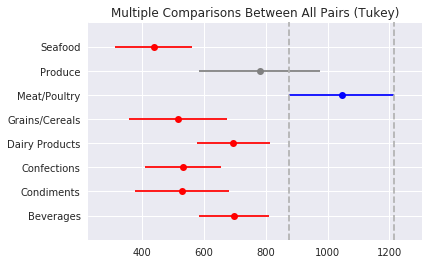

In [78]:
# let's compare all levels with Meat/Poultry (blue)
# all groups that are significantly different are color coded red, all insignificant groups gray
mc_results.plot_simultaneous(comparison_name='Meat/Poultry', figsize=(6,4));

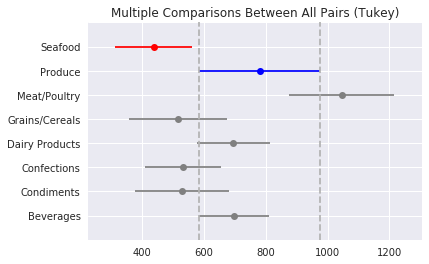

In [79]:
# let's compare all levels with Produce (blue)
# all groups that are significantly different are color coded red, all insignificant groups gray
mc_results.plot_simultaneous(comparison_name='Produce', figsize=(6,4));

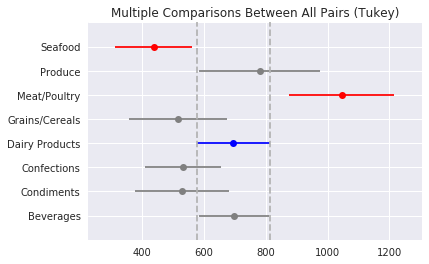

In [80]:
# let's compare all levels with Dairy Products (blue)
# all groups that are significantly different are color coded red, all insignificant groups gray
mc_results.plot_simultaneous(comparison_name='Dairy Products', figsize=(6,4));

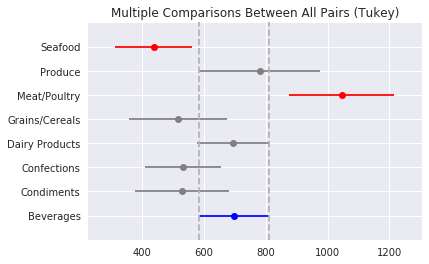

In [81]:
# let's compare all levels with Beverages (blue)
# all groups that are significantly different are color coded red, all insignificant groups gray
mc_results.plot_simultaneous(comparison_name='Beverages', figsize=(6,4));

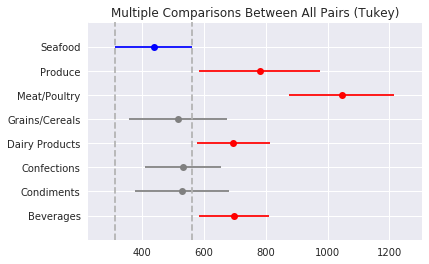

In [82]:
# let's compare all levels with Seafood (blue)
# all groups that are significantly different are color coded red, all insignificant groups gray
mc_results.plot_simultaneous(comparison_name='Seafood', figsize=(6,4));

Meat and poultry gain the highest spending.

### 4.4 - Conclusions

**A two-way ANOVA on an $\alpha$ = 0.05 was conducted to analyze the effect of gender and product category on net spending:**

* **Each factor**, gender and product category, has a **statistically highly significant effect** on the mean net expenditures: for gender with a p = 9.079449e-03 and for product category with a p = 5.902098e-09.

* The interaction term, though, was not significant (p = 0.918), indicating **no interaction effect** between gender and product category on mean expenditures. 

* Therefore I may partly reject the null hypothesis in support of the alternative: The mean spending between women and men are different. So are the mean spending for some of the product categories. Concerning the interaction effect, I support the null hypothesis.

* Post-hoc testing revealed interesting details in which groups actually differ: 1. Men spend significantly more than women. 2. Meat and poultry outperform most of the other product categories.

* However, the effect size is only small pointing to a **low practical significance**.

* My $\alpha$ = 0.05 effectively is the probability that I mistakenly reject the null hypothesis when it is actually true. This is called the "Type 1 Error". <br> With 5% I accept only a very small probability for Type 1 Error. The opposite is the "Type 2 Error" where I may mistakenly support the null hypothesis when the alternative is actually true.

**The results may be used to perhaps focus more on a male target group or draft marketing strategies to lift women's spending. Besides, the shop may also consider to diversify meat and poultry offers.**

## 5. Question: Different Volumes of Suppliers

> After analyzing so far 4 ideas to generate more money, now comes one that might help saving costs: <br> Are each shipping company's share in one region according to its overall share, i.e. is there no specific relationship between shipping company and region? <br> If not, may each shipper increasingly provided with higher volumes and/or freights in regions he already has an outstanding share - for the "admission fee" of sinking shipping costs?

### 5.1 - Exploratory Research

In [83]:
get_columns_info('Shipper')

Table Name: Shipper

Name: Id 	 Type: INTEGER
Name: CompanyName 	 Type: VARCHAR(8000)
Name: Phone 	 Type: VARCHAR(8000)


In [84]:
# joining "Order" and "Shipper" tables using the pd.read_sql_query() method
df5 = pd.read_sql_query('''SELECT * 
                            FROM [Order] o
                            JOIN Shipper s ON s.Id = o.ShipVia;''', engine)

In [85]:
print('1. Rows and Columns:')
print(df5.shape)
print('...............................')
print('\n2. Info:')
print(df5.info())
print('...............................\n\n3. Dataframe:')
df5.head()

1. Rows and Columns:
(830, 17)
...............................

2. Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 17 columns):
Id                830 non-null int64
CustomerId        830 non-null object
EmployeeId        830 non-null int64
OrderDate         830 non-null object
RequiredDate      830 non-null object
ShippedDate       809 non-null object
ShipVia           830 non-null int64
Freight           830 non-null float64
ShipName          830 non-null object
ShipAddress       830 non-null object
ShipCity          830 non-null object
ShipRegion        830 non-null object
ShipPostalCode    811 non-null object
ShipCountry       830 non-null object
Id                830 non-null int64
CompanyName       830 non-null object
Phone             830 non-null object
dtypes: float64(1), int64(4), object(12)
memory usage: 110.3+ KB
None
...............................

3. Dataframe:


,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,Id,CompanyName,Phone
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,3,Federal Shipping,(503) 555-9931
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,1,Speedy Express,(503) 555-9831
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil,2,United Package,(503) 555-3199
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France,1,Speedy Express,(503) 555-9831
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium,2,United Package,(503) 555-3199


In [86]:
df5.ShipRegion.unique()

array(['Western Europe', 'South America', 'Central America',
       'North America', 'Northern Europe', 'Scandinavia',
       'Southern Europe', 'British Isles', 'Eastern Europe'], dtype=object)

### Feature Engineering

We have to create a dataframe with the observed values per shipping company per region:

In [87]:
# oberserved values for each shipper by grouping
df5_observed = df5.groupby(['CompanyName', 'ShipRegion'])['Freight'].sum()
# unstack dataframe for more readability
df5_observed = df5_observed.unstack()
# add row sum
df5_observed['ROW_TOTAL'] = df5_observed.sum(axis=1)
# change index column's name
df5_observed.index.names = ['Sample']
df5_observed.head()

ShipRegion,British Isles,Central America,Eastern Europe,North America,Northern Europe,Scandinavia,South America,Southern Europe,Western Europe,ROW_TOTAL
Sample,,,,,,,,,,
Federal Shipping,1586.83,418.34,66.06,6546.28,912.43,271.94,1640.30,587.92,8482.41,20512.51
Speedy Express,998.59,176.31,8.72,2578.82,1369.54,291.38,2496.23,705.70,7560.04,16185.33
United Package,3124.09,528.13,100.96,6844.28,2351.82,623.07,4077.42,1076.24,9518.84,28244.85


Secondly, we have to build a dataframe with the expected values - to compare oberserved vs. expected volume:

In [88]:
# adding the "sample" column to the original dataframe df5 ...
df5['Sample'] = 'COLUM_TOTAL'

# ... to make the same unstacking possible for the expected values as we did with the observed

# create expected values:
df5_expected = df5.groupby(['Sample', 'ShipRegion'])['Freight'].sum()
# unstack dataframe for more readability
df5_expected = df5_expected.unstack()
# add row sum
df5_expected['ROW_TOTAL'] = df5_expected.sum(axis=1)

df5_expected

ShipRegion,British Isles,Central America,Eastern Europe,North America,Northern Europe,Scandinavia,South America,Southern Europe,Western Europe,ROW_TOTAL
Sample,,,,,,,,,,
COLUM_TOTAL,5709.51,1122.78,175.74,15969.38,4633.79,1186.39,8213.95,2369.86,25561.29,64942.69


In [89]:
# concat both tables to ONE frequency table
df5_crosstab = pd.concat([df5_observed, df5_expected], axis=0)
df5_crosstab

ShipRegion,British Isles,Central America,Eastern Europe,North America,Northern Europe,Scandinavia,South America,Southern Europe,Western Europe,ROW_TOTAL
Sample,,,,,,,,,,
Federal Shipping,1586.83,418.34,66.06,6546.28,912.43,271.94,1640.30,587.92,8482.41,20512.51
Speedy Express,998.59,176.31,8.72,2578.82,1369.54,291.38,2496.23,705.70,7560.04,16185.33
United Package,3124.09,528.13,100.96,6844.28,2351.82,623.07,4077.42,1076.24,9518.84,28244.85
COLUM_TOTAL,5709.51,1122.78,175.74,15969.38,4633.79,1186.39,8213.95,2369.86,25561.29,64942.69


### 5.2 - Hypothesis

$H_0$: There is no relationship between each shipping company's freight volume and its supplied regions. Both categorical variables are probabilistically independent and each company has the same share in each region as it has globally:

> $H_0: X_1 = X_2, ..., = X_m$

$H_1$: There is a relationship between each shipping company's freight volume and its supplied regions.

> $H_1: X_i \neq X_j$

I set my significance level: 

> **$\alpha$ = 0.05**

### 5.3 - Statistical Analysis

### Appropriate Test

To determine whether the proportions of all three shippers in the nine regions are the same, a **$\chi^2$ - Test of Independence** is appropriate.

Because of the $\chi^2$ - Distribution's shape, the significance level is always specified on the right (no one-tailed or two-tailed specification is necessary).

####  Chi-Square's Assumptions

* When testing the data, the cells should be **frequencies** or counts of cases and not percentages. --> Okay.

* The levels (categories) of the variables being tested are **mutually exclusive**. --> Okay.

* Each participant contributes to only one cell within the Chi-square table. --> Okay.

* The groups being tested must be **independent**. --> Okay.

* The value of **expected cells should be greater than 5.** --> Assumption is met, see calculation below.

### Test Statistic

In [90]:
# using the crosstab I built
df5_crosstab

ShipRegion,British Isles,Central America,Eastern Europe,North America,Northern Europe,Scandinavia,South America,Southern Europe,Western Europe,ROW_TOTAL
Sample,,,,,,,,,,
Federal Shipping,1586.83,418.34,66.06,6546.28,912.43,271.94,1640.30,587.92,8482.41,20512.51
Speedy Express,998.59,176.31,8.72,2578.82,1369.54,291.38,2496.23,705.70,7560.04,16185.33
United Package,3124.09,528.13,100.96,6844.28,2351.82,623.07,4077.42,1076.24,9518.84,28244.85
COLUM_TOTAL,5709.51,1122.78,175.74,15969.38,4633.79,1186.39,8213.95,2369.86,25561.29,64942.69


As I had some joy, I built my own **function to calculate the test statistic**:

In [91]:
def chi_statistic(dataframe):
    """ Function that takes in the dataframe and calculates the Chi Statistic 
    for Chi-Square test of homogeneity by:
    
    a) computing the expected frequency:
    E(i,j) = (Row Total * Column Total) / Grand Total
    
    b) calculating Chi-Squared:
    squaring the product of observed (O) and the expected (E) frequencies, 
    dividing it by E and 
    summing all values up:
    chi = Σ of ( (O(i,j) * E(i,j)) **2 ) / E(i,j) """
    
    # calculate grand
    grand_total = dataframe.iloc[3, 9]    
    
    # define an empty list for ALL expected chi-values
    chi_total = []
    
    # iterate through all rows (=samples)
    for row_j in range(0,3):
        
        # calculate row_total for each row
        row_total = dataframe.iloc[row_j, 9]
        
        # define an empty list for the expected chi-values per single row
        chi_per_row = []
        
        # iterate through all columns in that row (= features)
        for column_i in range(0,10):
            
            # calculate the column total
            col_total = dataframe.iloc[3, column_i]
            # grab the observed value
            obs_value = dataframe.iloc[row_j, column_i]
            # calculate first the expected frequency
            exp_value = (row_total * col_total) / grand_total
            # calculate secondly "single" chi value
            single_chi = ((obs_value-exp_value)**2) / exp_value
            # append them to the list
            chi_per_row.append(single_chi)
        
        # append the sum of row-wise chi-values to the overall list
        chi_total.append(sum(chi_per_row))
    
    # sum all values up to get the chi-squared
    return sum(chi_total)

In [92]:
# and now let's run it:
chi_statistic(df5_crosstab)

2757.5246458453066

In [93]:
# getting the degrees of freedom: df = (n − 1) * (m − 1) where n=samples and m=features
df = (3-1) * (9-1)
df

16

Checking a Chi table, it reveals: 

For df = 16 and $\alpha = 0.05$ the critical value of chi-squared is 26.296 - even for $\alpha = 0.01$ the value is 32.000, i.e. our test statistics is much higher and **we can reject the null hypothesis**.

In [94]:
# using ALSO the built-in chi contingency function to get the p value
chi, p, df, exp_frequencies = stats.chi2_contingency(df5_crosstab)
print(f"Chi Statistic:        {chi}")
print(f"p-value (two-tailed): {p:.12f}")

Chi Statistic:        2757.5246458453066
p-value (two-tailed): 0.000000000000


The Chi-square value matches the one we calculated in our function. And the p-value indicates a **highly significantly result**.

In [95]:
print("Expected Frequencies:", exp_frequencies)

Expected Frequencies: [[1.80338050e+03 3.54636311e+02 5.55084569e+01 5.04401753e+03
  1.46360836e+03 3.74727883e+02 2.59442181e+03 7.48533468e+02
  8.07367568e+03 2.05125100e+04]
 [1.42295158e+03 2.79824639e+02 4.37987693e+01 3.97996580e+03
  1.15485546e+03 2.95677830e+02 2.04712018e+03 5.90627924e+02
  6.37050781e+03 1.61853300e+04]
 [2.48317791e+03 4.88319050e+02 7.64327739e+01 6.94539667e+03
  2.01532618e+03 5.15984287e+02 3.57240801e+03 1.03069861e+03
  1.11171065e+04 2.82448500e+04]
 [5.70951000e+03 1.12278000e+03 1.75740000e+02 1.59693800e+04
  4.63379000e+03 1.18639000e+03 8.21395000e+03 2.36986000e+03
  2.55612900e+04 6.49426900e+04]]


--> Since **all of the expected frequencies are greater than 5**, the chi2 test results can be trusted.

#### Effect Size

The effect size for a Chi-square test can be calculated with Cramer’s V:
> #### $V= \sqrt{ \frac{\chi^2} {n * df} } $

In [96]:
import math

# chi-value we calculated with our function
chi = chi_statistic(df5_crosstab)

# observations, i.e. the length of original dataframe
n = df5.shape[0]

# df = degress of freedom we calculated above
df = df

v = math.sqrt(chi/(n*df))
v

0.35078318989327995

According to Cohen, this constitutes an almost **median effect**.

### 5.4 - Conclusions

**A Chi-Square Test of Independence on an $\alpha$ = 0.05 was used to analyze, whether the variables "shipping company" and "region" are probabilistically independent and so whether each shipping company has the same share in each region as it has globally:**

* There was a **statistically highly significant difference** between n = 3 shipping companies and m = 9 regions with p = 0.0000000.

* Therefore I may reject the null hypothesis in support of the alternative: There is indeed a relationship between each shipping company's freight volume and supplied regions.

* The effect size points to a median effect so we explored a **medium practical significance**.

* My $\alpha$ = 0.05 effectively is the probability that I mistakenly reject the null hypothesis when it is actually true. This is called the "Type 1 Error". <br> With 5% I accept only a very small probability for Type 1 Error. The opposite is the "Type 2 Error" where I may mistakenly support the null hypothesis when the alternative is actually true.

**The results could be used to provide shipping companies with already high volumes and/or freights in specific regions with increasing shares in exchange for reduced shipping costs. Examples: Federal Shipping has an already high share in North America, Speedy Express in Western Europe etc.**

In [97]:
# original crosstable
df5_crosstab

ShipRegion,British Isles,Central America,Eastern Europe,North America,Northern Europe,Scandinavia,South America,Southern Europe,Western Europe,ROW_TOTAL
Sample,,,,,,,,,,
Federal Shipping,1586.83,418.34,66.06,6546.28,912.43,271.94,1640.30,587.92,8482.41,20512.51
Speedy Express,998.59,176.31,8.72,2578.82,1369.54,291.38,2496.23,705.70,7560.04,16185.33
United Package,3124.09,528.13,100.96,6844.28,2351.82,623.07,4077.42,1076.24,9518.84,28244.85
COLUM_TOTAL,5709.51,1122.78,175.74,15969.38,4633.79,1186.39,8213.95,2369.86,25561.29,64942.69


In [98]:
# unelegant way to transform all values into percentages (row-wise calculated!)
df5_crosstab['British Isles'] = (df5_crosstab['British Isles'] / df5_crosstab['ROW_TOTAL'])*100
df5_crosstab['Central America'] = (df5_crosstab['Central America'] / df5_crosstab['ROW_TOTAL'])*100
df5_crosstab['Eastern Europe'] = (df5_crosstab['Eastern Europe'] / df5_crosstab['ROW_TOTAL'])*100
df5_crosstab['North America'] = (df5_crosstab['North America'] / df5_crosstab['ROW_TOTAL'])*100
df5_crosstab['Northern Europe'] = (df5_crosstab['Northern Europe'] / df5_crosstab['ROW_TOTAL'])*100
df5_crosstab['Scandinavia'] = (df5_crosstab['Scandinavia'] / df5_crosstab['ROW_TOTAL'])*100
df5_crosstab['South America'] = (df5_crosstab['South America'] / df5_crosstab['ROW_TOTAL'])*100
df5_crosstab['Southern Europe'] = (df5_crosstab['Southern Europe'] / df5_crosstab['ROW_TOTAL'])*100
df5_crosstab['Western Europe'] = (df5_crosstab['Western Europe'] / df5_crosstab['ROW_TOTAL'])*100
df5_crosstab['ROW_TOTAL'] = (df5_crosstab['ROW_TOTAL'] / df5_crosstab['ROW_TOTAL'])*100
df5_crosstab

ShipRegion,British Isles,Central America,Eastern Europe,North America,Northern Europe,Scandinavia,South America,Southern Europe,Western Europe,ROW_TOTAL
Sample,,,,,,,,,,
Federal Shipping,7.735913,2.039438,0.322047,31.913598,4.448164,1.325728,7.996584,2.866153,41.352375,100.0
Speedy Express,6.169723,1.089320,0.053876,15.933070,8.461613,1.800272,15.422793,4.360121,46.709211,100.0
United Package,11.060742,1.869828,0.357446,24.231957,8.326544,2.205960,14.435977,3.810394,33.701153,100.0
COLUM_TOTAL,8.791613,1.728878,0.270608,24.589958,7.135199,1.826826,12.647998,3.649156,39.359765,100.0
